<a href="https://colab.research.google.com/github/boyoungbk/sentiment_analysis-for_students-/blob/main/%EC%84%B1%EC%B0%B0%EC%9D%BC%EC%A7%80_%EA%B0%90%EC%84%B1_%EB%B6%84%EC%84%9D%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://trends.google.co.kr/trends/explore?date=all&q=%2Fm%2F0g57xn

# 실습 전 설치해야할 것

* colab에서 런타임 끊기는 것 방지
* 아래 코드를 복사하고 F12를 눌러 콘솔창에 붙여넣기 하세요.

function ClickConnect() {var buttons = document.querySelectorAll("colab-dialog.yes-no-dialog paper-button#cancel"); buttons.forEach(function(btn) { btn.click(); }); console.log("1분마다 자동 재연결"); document.querySelector("colab-toolbar-button#connect").click(); } setInterval(ClickConnect,1000*60);



In [19]:
# rpy2 rmagic 실행: python에서 r 실행 가능
%load_ext rpy2.ipython
%config IPCompleter.greedy=True
%config InlineBackend.figure_format = 'retina'

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
%%R
install_pkgs <- function(pkgs) {
  
  # 신규 패키지 설치 
  new_pkgs <- pkgs[!(pkgs %in% installed.packages()[, "Package"])]
  if (length(new_pkgs))
      install.packages(new_pkgs, dependencies = TRUE)
  
  # 기존 패키지 library 불러오기
  sapply(pkgs, require, character.only = TRUE)
}

# 패키지 설치
packages <- c('tidyverse', 'SentimentAnalysis', 'data.table', 'wordcloud', 'RColorBrewer', 'showtext', 'igraph', 'tidygraph', 'qgraph')

install_pkgs(packages)

In [5]:
# 파이썬으로 KoNLPy 형태소 분석기 설치
!set -x \
&& pip install konlpy \
&& curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh | bash -x

+ pip install konlpy
     |████████████████████████████████| 19.4MB 1.2MB/s 
     |████████████████████████████████| 460kB 39.4MB/s 
     |████████████████████████████████| 92kB 10.4MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
+ curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh
+ bash -x
+ mecab_dicdir=/usr/local/lib/mecab/dic/mecab-ko-dic
+ set -e
++ uname
+ os=Linux
+ [[ ! Linux == \L\i\n\u\x ]]
+ hash sudo
+ sudo=sudo
+ python=python3
+ hash pyenv
+ at_user_site=
++ check_python_site_location_is_writable
++ python3 -
+ [[ 1 == \0 ]]
+ hash automake
+ echo 'Installing automake (A dependency for mecab-ko)'
Installing automake (A dependency for mecab-ko)
+ install_automake
+ '[' Linux == Linux ']'
++ grep -Ei 'debian|buntu|mint' /etc/lsb

In [ ]:
# 구글 drive와 Colab 연동 (코드 실행 후 링크 클릭하고 인증키 입력하세요.)
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

# Python으로 성찰일지 형태소 분석하기

In [7]:
# Python으로 형태소 분석하기
from konlpy.tag import Mecab
import pandas as pd
import re
mecab = Mecab()

stopwords = ['때문', '가지', '습니다', '합니다', '입니다', '집니다', '에게', '라고', '그리고', '그래서', '하지만', '으로', '면서', '에서', '는데', '이랑', '한다']

#텍스트에 포함되어 있는 특수 문자 제거
def clean_text(text):
  tidy_text = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', text) 
  return tidy_text

# 형태소 분석 함수 (2글자 이상 단어 & 불용어 제외)
def tokenizer(text):
  word_list = []
  tidy_text = clean_text(text)
  words = mecab.morphs(text)
  for word in words:
    if len(word) > 1 and word not in stopwords:
      word_list.append(word)
  return word_list

In [ ]:
# 토큰화 예제
text_ex = u'AI교육공학과 교육방법 정말 유익하고 재미 있습니다. 감사합니다. :D ❤'
print(tokenizer(text_ex))

In [9]:
# 예제 파일 형태소 분석 파일 저장
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/sentiment_analysis/sa_data.csv')
df['morphed_txt'] = df['sa_data'].apply(tokenizer)
df.to_csv('/content/gdrive/My Drive/Colab Notebooks/sentiment_analysis/tidy_sa_data.csv', index = False)

# 잘 저장되었나 확인
from google.colab import data_table
data_table.DataTable(df, include_index = False, num_rows_per_page = 5)

,name,sa_data,morphed_txt
0,뷔,나는 당황과 신남이 나를 표현하는 것 같다. 매일 할 일을 자주 잊어버리기 때문에 ...,"[당황, 신남, 표현, 매일, 자주, 잊어버리, 당황, 호기심, 여러, 신나, 열정]"
1,정국,첫번째 감성은 긴장입니다.발표를 시키는 룰렛을 돌릴때마다 혹시라도 제가 뽑힐까봐 긴...,"[감성, 긴장, 발표, 시키, 룰렛, 돌릴, 마다, 혹시, 라도, 뽑힐, 까봐, 긴..."
2,지민,나를 표현하는 가장 대표적인 감정은 기쁨이다. 나는 언제나 즐거운 일이 생각나고 그...,"[표현, 가장, 대표, 감정, 기쁨, 언제나, 즐거운, 생각나, 그런, 사소, 재미..."
3,슈가,감사: 내가 살아있는 것에 감사하며 항상 받는 배려와 1.다른 감정들이 존재한다는 ...,"[감사, 감사, 항상, 배려, 다른, 감정, 존재, 한다는, 감사, 기쁨, 친구, ..."
4,진,슬픔: 코로나 때문에 친구들과 놀지 못해서 슬프다.\n다음주 금요일에 사회시험이 있...,"[슬픔, 코로나, 친구, 못해서, 슬프, 다음, 금요일, 사회, 시험, 어서, 슬프..."
5,랩몬스터,"노력, 행복, 열정, 신남, 감사 ...","[노력, 행복, 열정, 신남, 감사, 이유, 노력, 결과, 다는, 노력, 중요, 생..."
6,제이홉,박주리 \n자신만만: 자신을 믿고서 자신을 매번 응원합니다. 항상 자신감을 같고 용...,"[주리, 자신, 자신, 고서, 자신, 매번, 응원, 항상, 자신감, 용기, 도전, ..."
7,진,외로움 새 자꾸 가을을 타는지 가끔 외로울 때가 있다. 아니면 그냥 외로운 걸...,"[외로움, 자꾸, 가을, 는지, 가끔, 외로울, 아니면, 그냥, 외로운, 누군가, ..."
8,쯔위,짜증.친구랑 놀려고 했을 때 친구가 갑자기 못 논다고 하면 짜증이 난다 ...,"[짜증, 친구, 려고, 친구, 갑자기, 논다고, 짜증, 난다, 행복, 맛있, 주로,..."
9,제니,자랑: 저는 제가 만든 물건이나 제가 한 일들을 자랑 하는 것을 좋아합니다. 자랑...,"[자랑, 만든, 물건, 이나, 자랑, 자랑, 다른, 사람, 칭찬, 기분, 신남, 어..."


# R로 성찰일지의 단어 워드클라우드 만들기


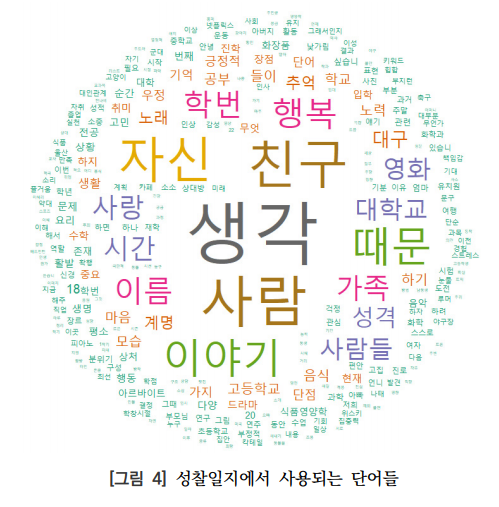

In [10]:
%%R
# ------------ 경로 변수 ------------

text_csv = '/content/gdrive/My Drive/Colab Notebooks/sentiment_analysis/tidy_sa_data.csv'
freq_csv = '/content/gdrive/My Drive/Colab Notebooks/sentiment_analysis/txt_freq.csv'
google_fontname = 'Noto Sans KR'

# -----------------------------------

In [ ]:
## Python에서 형태소 분석한 파일 R로 읽어와 다시 정리하기
%%R
txt <- fread(text_csv)
temp_txt <- unlist(txt$morphed_txt)
temp_txt <- gsub('[[:punct:]]', '', temp_txt)
word_list <- str_split(temp_txt, '\\s+')     # 공백 기준으로 단어 생성 -> \\s+ : 공백 정규식, +(1개 이상)

# txt 데이터프레임 수정
txt <- subset(txt, select = - morphed_txt)
txt$morphed_txt <- word_list

word_vec <-  unlist(word_list)     
wordcount <- table(word_vec)
wordcount <- sort(wordcount, decreasing = T)   # 빈도수 높은 순으로 정렬하기
write.csv(wordcount, file = freq_csv, row.names = FALSE)
head(wordcount, 30)   # 상위 30개 단어만 데이터프레임 살펴보기

In [ ]:
# R로 데이터프레임 워드클라우드 만들기
%%R
# Python으로 형태소 분석한 csv 파일 불러오기
rFreq <- fread(freq_csv)
print(head(rFreq$word_vec))
print(head(rFreq$Freq))

# RColoBrewer의 Palete를 사용하여 워드클라우드의 색 테마를 정한다.
palette <- brewer.pal(8, 'Dark2')

# 한글 폰트설정
font_add_google(google_fontname, 'font_kr')
showtext_auto()

# wordcloud 모양으로 그린다.
wordcloud(rFreq$word_vec, freq = rFreq$Freq, family = 'font_kr', min.freq = 3, rot.per = 0, random.order = FALSE, colors = palette)

# R로 감성분석 하기

<< [그림2] 연휴에 대한 네티즌의 감성 분석 >>

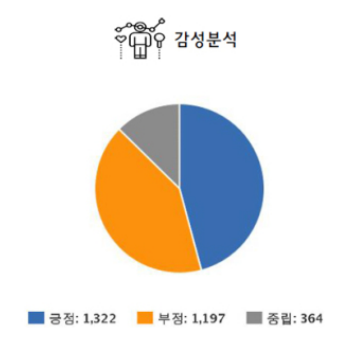

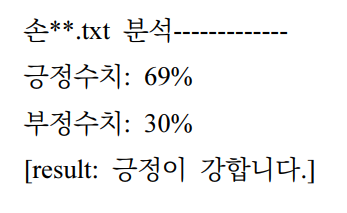

In [ ]:
%%R
senti_words_kr <- read_delim('/content/gdrive/My Drive/Colab Notebooks/sentiment_analysis/SentiWord_Dict.txt', delim='\t', col_names=c("term", "score"))
print(head(senti_words_kr))
dim(senti_words_kr)
table(senti_words_kr$term)[1:10]

In [ ]:
%%R
x <- duplicated(senti_words_kr$term)
senti_words_kr2 <- senti_words_kr[!x, ]
senti_dic_kr <- SentimentDictionaryWeighted(words = senti_words_kr2$term, 
                                            scores = senti_words_kr2$score)
senti_dic_kr <- SentimentDictionary(senti_words_kr2$term[senti_words_kr2$score > 0], 
                                    senti_words_kr2$term[senti_words_kr2$score < 0])

summary(senti_dic_kr)
senti_words_kr$term[duplicated(senti_words_kr$term)]

In [ ]:
%%R

# get_sentiment <- function(x) {
#     scores <- analyzeSentiment(x[,2],
#                     language = 'korean',
#                     rules = list('score' = list(ruleSentiment, senti_dic_kr)),
#                     removeStopwords = FALSE, stemming = FALSE)
#     result <- map(scores, function(x){if_else(x >= 0, 'positive', 'negative')})
    
# }

get_scores <- function(x) {
    analyzeSentiment(x,
                    language = 'korean',
                    rules = list('score' = list(ruleSentiment, senti_dic_kr)),
                    removeStopwords = FALSE, stemming = FALSE)
}

get_pn <- function(x) {
    result <- map(x, function(x){if_else(x >= 0, 'positive', 'negative')})
    return(result)
}

# txt <- select(txt, get_scores(txt$sa_data), get_pn(txt&score)

res_sentiment <- get_scores(txt$sa_data)

print(head(res_sentiment))

df2 <- data.frame(txt, round(res_sentiment,3))

result_df <- df2 %>% 
  mutate(result = if_else(score >= 0, 'positive', 'negative')) %>%
  select(everything(), result)

fwrite(result_df, file = '/content/gdrive/My Drive/Colab Notebooks/sentiment_analysis/sa_result.csv')

In [16]:
# 잘 저장되었나 확인
from google.colab import data_table
sa_df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/sentiment_analysis/sa_result.csv')
data_table.DataTable(sa_df, include_index = False, num_rows_per_page=5)

,name,sa_data,morphed_txt,score,result
0,뷔,나는 당황과 신남이 나를 표현하는 것 같다. 매일 할 일을 자주 잊어버리기 때문에 ...,당황|신남|표현|매일|자주|잊어버리|당황|호기심|여러|신나|열정,0.000,positive
1,정국,첫번째 감성은 긴장입니다.발표를 시키는 룰렛을 돌릴때마다 혹시라도 제가 뽑힐까봐 긴...,감성|긴장|발표|시키|룰렛|돌릴|마다|혹시|라도|뽑힐|까봐|긴장|발표|너무|해서|제...,0.000,positive
2,지민,나를 표현하는 가장 대표적인 감정은 기쁨이다. 나는 언제나 즐거운 일이 생각나고 그...,표현|가장|대표|감정|기쁨|언제나|즐거운|생각나|그런|사소|재미|는다|영어|학원|선...,0.029,positive
3,슈가,감사: 내가 살아있는 것에 감사하며 항상 받는 배려와 1.다른 감정들이 존재한다는 ...,감사|감사|항상|배려|다른|감정|존재|한다는|감사|기쁨|친구|가족|함께|기쁨|행복|...,-0.019,negative
4,진,슬픔: 코로나 때문에 친구들과 놀지 못해서 슬프다.\n다음주 금요일에 사회시험이 있...,슬픔|코로나|친구|못해서|슬프|다음|금요일|사회|시험|어서|슬프|기쁨|그래도|학교|...,0.020,positive
5,랩몬스터,"노력, 행복, 열정, 신남, 감사 ...",노력|행복|열정|신남|감사|이유|노력|결과|다는|노력|중요|생각|힘든|이루|위해|노...,0.050,positive
6,제이홉,박주리 \n자신만만: 자신을 믿고서 자신을 매번 응원합니다. 항상 자신감을 같고 용...,주리|자신|자신|고서|자신|매번|응원|항상|자신감|용기|도전|노력|기쁨|하나|칭찬|...,0.043,positive
7,진,외로움 새 자꾸 가을을 타는지 가끔 외로울 때가 있다. 아니면 그냥 외로운 걸...,외로움|자꾸|가을|는지|가끔|외로울|아니면|그냥|외로운|누군가|은데|친구|줘서|고맙...,0.078,positive
8,쯔위,짜증.친구랑 놀려고 했을 때 친구가 갑자기 못 논다고 하면 짜증이 난다 ...,짜증|친구|려고|친구|갑자기|논다고|짜증|난다|행복|맛있|주로|행복|카트라이더|랭킹...,0.000,positive
9,제니,자랑: 저는 제가 만든 물건이나 제가 한 일들을 자랑 하는 것을 좋아합니다. 자랑...,자랑|만든|물건|이나|자랑|자랑|다른|사람|칭찬|기분|신남|어떤|새로운|이나|처음|...,0.075,positive


In [ ]:
%%R
result_tb <- result_df %>%
  group_by(result) %>%
  summarize(count = n())

print(result_tb)

ggplot(result_tb, aes(x = '', y = count, fill = result)) +
  geom_bar(stat = 'identity', width = 1, color = 'white') +
  coord_polar(theta = 'y') +
  labs(
    title = '6-8 성찰일지 감성분석',
    subtitle = 'AI활용 교육방법 및 교육공학 세미나 발표 자료'
  ) +
  theme(
      legend.position = 'bottom',
      legend.title = element_blank(),
      axis.title.x = element_blank(),
      axis.text.x = element_blank(),
      axis.ticks.x = element_blank(),
      axis.title.y = element_blank(),
      axis.text.y = element_blank(),
      axis.ticks.y = element_blank()
  )

In [ ]:
%%R
ggplot(result_df, aes(score, name, color = result)) +
  geom_point(alpha = 0.9, size = 5) +
  labs(
    title = '6-8 성찰일지 감성분석',
    subtitle = 'AI활용 교육방법 및 교육공학 세미나 발표 자료'
  ) +
  theme(
      legend.position = 'bottom',
      legend.title = element_blank(),
      axis.title.x = element_blank(),
      axis.ticks.x = element_blank(),
      axis.title.y = element_blank(),
      axis.ticks.y = element_blank()
  )

# R로 성찰일지의 단어 상관분석하기


<< 참고자료 >>

* [자연어처리(NLP) (Term-Document Matrix, TDM)](https://medium.com/@omicro03/%EC%9E%90%EC%97%B0%EC%96%B4%EC%B2%98%EB%A6%AC-nlp-7%EC%9D%BC%EC%B0%A8-term-document-matrix-tdm-f959ce229ade)
* [최대한 친절하게 쓴 R로 사회연결망 분석하기](https://kuduz.tistory.com/1087)
* [R로 카카오톡 대화내용 분석하기](https://inspirit941.tistory.com/entry/R%EC%9D%84-%ED%99%9C%EC%9A%A9%ED%95%9C-%EC%B9%B4%EC%B9%B4%EC%98%A4%ED%86%A1-%EB%8C%80%ED%99%94%EB%82%B4%EC%9A%A9-%EB%B6%84%EC%84%9D)

<< [그림 2-1] 네티즌의 연휴 인식 분석 >>


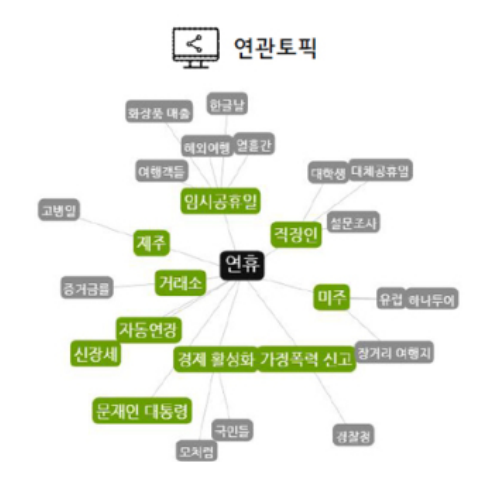


In [ ]:
%%R
rFreq <- rFreq[1:50,]
print(rFreq)
new_df <- rFreq %>% graph_from_data_frame()
V(new_df)$type <- bipartite_mapping(new_df)$type
new_mat <- as_incidence_matrix(new_df) %*% t(as_incidence_matrix(new_df))
diag(new_mat) <- 0
new_mat <- new_mat %>% graph_from_adjacency_matrix()

In [ ]:
%%R
pp <- get_scores(word_vec)
print(head(pp))

new_mat %>% plot(edge.arrow.size = 0.5, vertex.size = 30, vertex.frame.color = 'white', edge.lty = 'dashed', vertex.label.family = 'font_kr')